# Purpose
### In this analysis, I will group countries with similar characteristics in relation to the top 10 adverse event record through Kmeans Clustering.  Data will use the entire data for 2019.

# Import Modules

In [100]:
import json  
import pandas as pd  
from pandas.io.json import json_normalize  
import numpy as np
import time
import sklearn
import matplotlib.pyplot as plt

# Data Load

In [2]:
def loading_data(temp):
    data = pd.DataFrame()
    data['safetyreportid'] = temp['safetyreportid']  # read 'safetyreportid' column
    data['country'] = temp['occurcountry']  # read 'country' column
    
    data['patient.reaction'] = temp['patient.reaction'].apply(lambda x: x) # read 'patient.reaction' column
    stack = data.apply(lambda x: pd.Series(x['patient.reaction']), axis=1).stack().reset_index(level=1, drop=True) # split patient.reaction(list) to each different row
    stack.name = 'patient.reaction' # set the name
    data = data.drop('patient.reaction', axis=1) # drop patient.reaction column
    data = data.join(stack)
        
    data['reactionmeddrapt'] = data['patient.reaction'].apply(lambda x: x['reactionmeddrapt'])  # read 'reactionmeddrapt' from 'patient.reaction'
    data.drop('patient.reaction', axis = 1, inplace=True)  # remove unnecessary columns
    return data
    

In [3]:
start = time.time() 

df = pd.DataFrame()
for i in range(1,134):
    a = 'data (' + str(i) + ').json'
    with open(a) as f:
        d = json.load(f) 
    result = json_normalize(d['results']) 
    temp = loading_data(result)
    df = pd.concat([df, temp], sort=False)

    
end = time.time()
(end - start)/60

66.9860805273056

In [370]:
# df.to_csv('C:\AstraZeneca\df.csv')

In [384]:
# df = pd.read_csv('C:\AstraZeneca\df.csv', index_col=0)

# Data Cleansing

In [372]:
# Drop missing value
df.dropna(inplace=True)

### Bring data having Top 10 Reactions

In [373]:
top_list = df['reactionmeddrapt'].value_counts().head(10)
top_list = list(top_list.index)
df = df[df['reactionmeddrapt'].apply(lambda x: x in top_list)]

### Aggregation with the number of cases by a country

In [374]:
cnt_cntr = pd.DataFrame({'total_case': df['country'].value_counts()})
df = pd.DataFrame(df.groupby(['country','reactionmeddrapt']).size(), columns=['count']).reset_index('reactionmeddrapt')
df = df.join(cnt_cntr)

### Add percent of cases by a country

In [375]:
df['percent'] = df['count'] / df['total_case']

In [376]:
df = df.reset_index().rename(columns={'index': 'country'})

# Kmeans Clustering

In [377]:
knn_table = pd.pivot_table(df, values='percent', index=['country'],
                    columns=['reactionmeddrapt'], fill_value = 0)

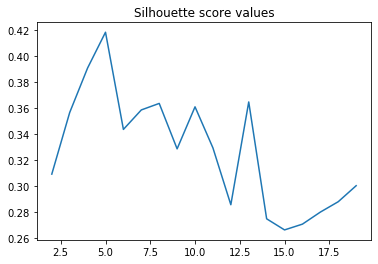

In [378]:
# Check the best number of cluster with Silhouette metrics

from sklearn import cluster

NumberOfClusters=range(2,20)
silhouette_score_values = []

for i in NumberOfClusters:
    
    classifier=cluster.KMeans(i,init='k-means++', random_state=0)
    classifier.fit(knn_table)
    labels= classifier.predict(knn_table)
    silhouette_score_values.append(sklearn.metrics.silhouette_score(knn_table,labels ,metric='euclidean', sample_size=None, random_state=None))
 
plt.plot(NumberOfClusters, silhouette_score_values)
plt.title("Silhouette score values")
plt.show()

In [379]:
# Fit with  5 clusters
estimator = KMeans(n_clusters=5, init='k-means++', random_state=0)
estimator.fit(knn_table)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [380]:
# Check the characteristics of the 5 clusters
knn_result = pd.DataFrame(estimator.cluster_centers_, columns=knn_table.columns)
knn_result['size'] = pd.Series(estimator.labels_).value_counts()
round(knn_result, 2)

reactionmeddrapt,Death,Diarrhoea,Drug ineffective,Dyspnoea,Fatigue,Headache,Malaise,Nausea,Off label use,Pain,size
0,0.69,0.02,0.06,0.06,0.01,0.03,0.02,0.02,0.07,0.01,41
1,0.15,0.09,0.12,0.09,0.10,0.07,0.06,0.12,0.14,0.05,111
2,0.00,0.00,0.07,0.75,0.07,0.00,-0.00,0.06,0.05,0.00,7
3,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,5
4,0.01,0.02,0.93,0.00,0.01,0.01,0.00,0.00,0.02,0.00,6


In [381]:
# Add cluster label
knn_table = knn_table.reset_index()
knn_df = pd.concat([knn_table, pd.Series(estimator.labels_)], axis=1, sort=False)
knn_df = knn_df.rename(columns={0:'KNN_Cluster'})

In [382]:
# Add total cases by a country
knn_df.set_index('country', inplace = True)
knn_df = knn_df.join(cnt_cntr)
knn_df

,Death,Diarrhoea,Drug ineffective,Dyspnoea,Fatigue,Headache,Malaise,Nausea,Off label use,Pain,KNN_Cluster,total_case
country,,,,,,,,,,,,
AD,0.000000,0.000000,0.000000,0.250000,0.000000,0.250000,0.250000,0.000000,0.000000,0.250000,1,4
AE,0.161017,0.025424,0.093220,0.144068,0.152542,0.076271,0.042373,0.093220,0.169492,0.042373,1,118
AF,0.500000,0.125000,0.062500,0.125000,0.000000,0.000000,0.000000,0.187500,0.000000,0.000000,0,16
AL,0.000000,0.285714,0.000000,0.142857,0.142857,0.142857,0.000000,0.142857,0.142857,0.000000,1,7
AM,0.272727,0.000000,0.090909,0.090909,0.000000,0.000000,0.181818,0.090909,0.272727,0.000000,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...
VE,0.108108,0.081081,0.162162,0.081081,0.135135,0.054054,0.135135,0.081081,0.081081,0.081081,1,37
VG,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,1,3
VN,0.286713,0.132867,0.097902,0.111888,0.132867,0.027972,0.000000,0.062937,0.139860,0.006993,1,143


In [383]:
# Example data with Cluster 0
knn_df[(knn_df['KNN_Cluster'] == 0)]

,Death,Diarrhoea,Drug ineffective,Dyspnoea,Fatigue,Headache,Malaise,Nausea,Off label use,Pain,KNN_Cluster,total_case
country,,,,,,,,,,,,
AF,0.500000,0.125000,0.062500,0.125000,0.000000,0.000000,0.000000,0.187500,0.000000,0.000000,0,16
AX,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1
BD,0.530612,0.061224,0.081633,0.081633,0.020408,0.000000,0.040816,0.040816,0.122449,0.020408,0,49
BN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,2
BO,0.533333,0.000000,0.066667,0.000000,0.000000,0.066667,0.066667,0.000000,0.266667,0.000000,0,15
BT,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1
BW,0.958333,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0,24
CU,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0,5
DZ,0.433962,0.094340,0.075472,0.075472,0.075472,0.037736,0.000000,0.018868,0.169811,0.018868,0,53
